# 1 predict.ipynb

该文件完成了以下工作

1. 输入手写四则运算图片，运用连通图提取的方法，对算式进行字符分割
2. 加载训练好的模型，进行预测
3. 对手写四则运算进行计算

-------------------

## 1.1 预处理

导入相应的模块，加载预训练模型，创建一个映射

In [5]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 加载模型
model = load_model('cnn-lstm.h5')

# 16个预测标签和真实字符的对应关系
char_map = {
    0: '(', 1: ')', 2: '0', 3: '1', 4: '2',
    5: '3', 6: '4', 7: '5', 8: '6', 9: '7',
    10: '8', 11: '9', 12: '/', 13: '*', 14: '+', 15: '-'
}


---

## 1.1 predict函数

 - 该函数通过连通图提取的办法，对字符进行区域划分，从而将手写四则运算切割成一个个单个字符
 - 对每一个字符子图，经过一系列图形处理，转变成28*28的图像，作为模型的输入，进行预测，预测结果存入`predictions`列表
 - 将`predictions`列表拼接成字符串，转成算术表达式，执行即可得到手写四则运算的结果
 - 最后补上可视化结果

> 1. 这部分代码中我对图像进行了很多处理，比如`image = cv2.blur(image, (5, 5)); image[image != 255] = 0`，用于增强像素，因为在缩放过程中，会导致像素值的缺失。
> 2. 连通图提取的时候，会把除号分成三个部分，于是我采用了竖向剪切的方法。

---

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def predict(path):
    # 加载输入图像
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # 高斯模糊+像素增强
    image = cv2.blur(image, (5, 5))
    image[image != 255] = 0

    # 图像二值化处理
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

    # 连通图提取
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # 提取字符区域
    character_regions = []
    for i in range(1, num_labels):
        # 连通图的矩形边界
        left = stats[i, cv2.CC_STAT_LEFT]
        top = stats[i, cv2.CC_STAT_TOP]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]

        # 对于过小的区域，跳过（比如除号的上下两点）
        if width * height < 500:
            continue

        # 竖向裁剪
        top = 0
        height = binary_image.shape[0] - 1
        character_regions.append((left, top, width, height))

    # 按照从左到右的顺序排序字符区域
    character_regions.sort(key=lambda x: x[0])

    # 预测结果
    predictions = []

    # 显示字符子图
    for i, (left, top, width, height) in enumerate(character_regions):
        character_image = binary_image[top:top + height, left:left + width]  # 裁出子图
        # 反转二值化图像
        character_image = cv2.bitwise_not(character_image)

        # 确定调整大小的尺寸
        target_size = (28, 28)
        ratio = min(target_size[0] / character_image.shape[1], target_size[1] / character_image.shape[0])
        new_size = (int(character_image.shape[1] * ratio), int(character_image.shape[0] * ratio))

        # 调整大小并居中
        if new_size[0] <= 0 or new_size[1] <= 0:
            continue

        resized_image = cv2.resize(character_image, new_size, interpolation=cv2.INTER_AREA)

        delta_w = target_size[0] - resized_image.shape[1]
        delta_h = target_size[1] - resized_image.shape[0]
        top_pad = delta_h // 2
        bottom_pad = delta_h - top_pad
        left_pad = delta_w // 2
        right_pad = delta_w - left_pad
        padded_image = cv2.copyMakeBorder(resized_image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT,
                                          value=255)

        # 对比度增强
        image = cv2.equalizeHist(image)

        # 边缘增强
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        image = cv2.filter2D(image, -1, kernel)

        # 保存切割的子图
        # cv2.imwrite(f'./character_{i}.png', padded_image)

        # 创建新的图像
        plt.figure(figsize=(1, 0.25))

        # 显示切割的子图
        plt.imshow(padded_image, cmap='gray')
        plt.axis('off')
        plt.show()

        # 进行预测
        normalized_image = padded_image / 255.0  # 将像素值归一化到 [0, 1]
        input_image = np.expand_dims(normalized_image, axis=2)
        input_image = np.expand_dims(input_image, axis=0)
        prediction = model.predict(input_image)
        predicted_index = np.argmax(prediction)
        predicted_label = char_map[predicted_index] # 找到真实的标签

        predictions.append(predicted_label)

    # 输出预测结果
    print(predictions)

    # 输出保存的子图数量
    # print(f"保存了 {len(character_regions)} 张子图。")

    # ========================================  进行四则运算 =======================================
    t = str()
    for i in range(len(predictions)):
        t = t + predictions[i]      # 将列表中的字符拼成字符串

    result = eval(t)        # 字符串转成算式
    print(t)
    print(result)           # 输出计算结果


---

## 1.2 单个图片的测试

输入路径，对单个手写四则运算进行测试

---

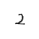

1/1 [==============================] - 0s 22ms/step


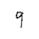

1/1 [==============================] - 0s 17ms/step


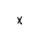

1/1 [==============================] - 0s 18ms/step


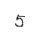

1/1 [==============================] - 0s 18ms/step


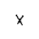

1/1 [==============================] - 0s 18ms/step


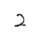

1/1 [==============================] - 0s 18ms/step
['2', '9', '*', '5', '*', '2']
29*5*2
290


In [9]:
# 单个图片的预测测试
path = "./mnist+/test/7.jpg"
predict(path)

---

## 1.3 对所有测试样例进行批处理，统计测试集正确率

在执行下面代码前，建议先将上面`predict`函数中，绘制子图的代码注释掉，只需要看输出结果就好了。否则会产生大量子图，不利于看批处理的结果。

由于其他种种因素，测试集表现似乎一般

---

In [7]:
import os

# 指定文件夹路径
folder_path = "./mnist+/test"

# 计数器
right_ans = 0
error_count = 0

# 遍历文件夹
for file_name in sorted(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        try:
            predict(file_path)
            right_ans += 1
        except:
            error_count += 1

print(' ')
print(' ')
print("+++++++++++++++++++测试结束+++++++++++++++++")
print(f'正确个数：{right_ans}')
print(f'错误次数：{error_count}')


1/1 [==============================] - 0s 17ms/step
['3', '*', '*', '2', '/', '2']
3**2/2
4.5
1/1 [==============================] - 0s 17ms/step
['1', '*', '-', '*', '*', '*']
1/1 [==============================] - 0s 16ms/step
['*', '*', '-', '*', '*', '*', '*']
1/1 [==============================] - 0s 17ms/step
['2', '*', '6', '-', '1']
2*6-1
11
1/1 [==============================] - 0s 17ms/step
['*', '+', '(', '+', '2']
1/1 [==============================] - 0s 15ms/step
['+', '+', '6', '+', '1']
++6+1
7
1/1 [==============================] - 0s 16ms/step
['2', '/', '2', '*', '3']
2/2*3
3.0
1/1 [==============================] - 0s 17ms/step
['+', '+', '3', '-', '2']
++3-2
1
1/1 [==============================] - 0s 16ms/step
['1', '+', '5', '-', '7']
1+5-7
-1
1/1 [==============================] - 0s 16ms/step
['4', '1', '*', '3']
41*3
123
1/1 [==============================] - 0s 15ms/step
['1', '9', '*', '3', '-', '1', '1']
19*3-11
46
1/1 [==============================] - 0s 